In [14]:
import pandas as pd
import numpy as np

import yfinance as yf

import matplotlib.pyplot as plot
import seaborn as sns

import torch
from torch.nn import Module, LSTM, Linear, Softmax

from plotting import set_plot_style

set_plot_style()

In [15]:
from snp.SNP500 import SNP500

tickers = ["VTI", "AGG", "DBC", "^VIX", "AAPL", "MSFT", "AMZN", "META", "V", "AEP", "GOOG", "NVDA"]

start_date = "2006-06-16"
end_date = "2023-09-16"

data = yf.download(tickers, start_date, end_date)
data.to_csv("data/data.csv")

data = pd.read_csv('data/data.csv', header=[0, 1], index_col=0, parse_dates=True)

[*********************100%***********************]  12 of 12 completed


In [16]:
# We want only the adjusted closing prices
index_prices = data["Adj Close"].dropna(axis=1)
index_prices.head()

,AAPL,AEP,AGG,AMZN,DBC,GOOG,MSFT,NVDA,VTI,^VIX
Date,,,,,,,,,,
2006-06-16,1.744883,17.301352,58.167381,1.7545,22.051857,9.731026,15.785866,3.311907,44.901226,17.250000
2006-06-19,1.733970,17.230438,58.012623,1.7535,21.644327,9.667265,16.107294,3.212520,44.449505,17.830000
2006-06-20,1.742155,17.260832,58.048317,1.7740,21.825453,9.643105,16.114439,3.162062,44.460331,16.690001
2006-06-21,1.753978,17.240574,58.066193,1.8325,22.142420,10.015709,16.485876,3.197229,44.955437,15.520000
2006-06-22,1.806117,17.184858,57.816277,1.8185,22.133364,9.961412,16.343008,3.103957,44.709690,15.880000


In [17]:
# Compute log returns for stocks
log_returns = np.log(index_prices).diff()[1:]

# Reindex prices to match log returns
index_prices = index_prices.reindex(log_returns.index)

log_returns.head()

,AAPL,AEP,AGG,AMZN,DBC,GOOG,MSFT,NVDA,VTI,^VIX
Date,,,,,,,,,,
2006-06-19,-0.006274,-0.004107,-0.002664,-0.000570,-0.018653,-0.006574,0.020157,-0.030468,-0.010111,0.033070
2006-06-20,0.004710,0.001762,0.000615,0.011623,0.008333,-0.002502,0.000443,-0.015831,0.000244,-0.066073
2006-06-21,0.006763,-0.001174,0.000308,0.032444,0.014418,0.037912,0.022788,0.011060,0.011074,-0.072680
2006-06-22,0.029293,-0.003237,-0.004313,-0.007669,-0.000409,-0.005436,-0.008704,-0.029607,-0.005481,0.022931
2006-06-23,-0.012668,-0.000884,0.000514,0.004937,-0.002048,0.012202,-0.016747,0.000493,0.001535,0.000630


In [18]:
# Combine prices and returns
combined = pd.concat([index_prices, log_returns], axis=1)

combined.head()

,AAPL,AEP,AGG,AMZN,DBC,GOOG,MSFT,NVDA,VTI,^VIX,AAPL,AEP,AGG,AMZN,DBC,GOOG,MSFT,NVDA,VTI,^VIX
Date,,,,,,,,,,,,,,,,,,,,
2006-06-19,1.733970,17.230438,58.012623,1.7535,21.644327,9.667265,16.107294,3.212520,44.449505,17.830000,-0.006274,-0.004107,-0.002664,-0.000570,-0.018653,-0.006574,0.020157,-0.030468,-0.010111,0.033070
2006-06-20,1.742155,17.260832,58.048317,1.7740,21.825453,9.643105,16.114439,3.162062,44.460331,16.690001,0.004710,0.001762,0.000615,0.011623,0.008333,-0.002502,0.000443,-0.015831,0.000244,-0.066073
2006-06-21,1.753978,17.240574,58.066193,1.8325,22.142420,10.015709,16.485876,3.197229,44.955437,15.520000,0.006763,-0.001174,0.000308,0.032444,0.014418,0.037912,0.022788,0.011060,0.011074,-0.072680
2006-06-22,1.806117,17.184858,57.816277,1.8185,22.133364,9.961412,16.343008,3.103957,44.709690,15.880000,0.029293,-0.003237,-0.004313,-0.007669,-0.000409,-0.005436,-0.008704,-0.029607,-0.005481,0.022931
2006-06-23,1.783381,17.169666,57.845997,1.8275,22.088081,10.083704,16.071585,3.105487,44.778362,15.890000,-0.012668,-0.000884,0.000514,0.004937,-0.002048,0.012202,-0.016747,0.000493,0.001535,0.000630


In [19]:
# Set the lookback period to 50 days
lookback = 50

# Calculate the number of samples, subtracting the lookback period from the total length of 'combined'
n_samples = len(combined) - lookback

# Determine the number of features (columns) in the 'combined' DataFrame
n_features = len(combined.columns)

# Number of targets = number of assets
n_targets = len(index_prices.columns)

# Initialize an empty NumPy array for the feature set with dimensions (n_samples, lookback, n_features)
X = np.zeros((n_samples, lookback, n_features))

# Create the target set 'y' by removing the first 'lookback' rows from 'log_returns'
y = log_returns.iloc[lookback:].values

# Populate the 'X' array with feature data
for i in range(lookback, len(combined)):
    # For each sample, store a sequence of 'lookback' rows from 'combined' into 'X'
    X[i-lookback] = combined.iloc[i-lookback:i]

X.shape, y.shape

((4291, 50, 20), (4291, 10))

In [20]:
def to_tensor(D):
    return torch.tensor(D, dtype=torch.float32)

def to_tensors(*D):
    tensors = []
    for d in D:
        tensors.append(to_tensor(d))
    return tuple(tensors)

test_size = .4
slice_idx = int(len(X) * test_size)

X_train, X_test = X[:-slice_idx], X[-slice_idx:]
y_train, y_test = y[:-slice_idx], y[-slice_idx:]

X_train_tens, X_test_tens, y_train_tens, y_test_tens = to_tensors(
    X_train, X_test, y_train, y_test
)

X_train_tens.shape, X_test_tens.shape, y_train_tens.shape, y_test_tens.shape

(torch.Size([2575, 50, 20]),
 torch.Size([1716, 50, 20]),
 torch.Size([2575, 10]),
 torch.Size([1716, 10]))

In [21]:
def sharpe_ratio(weights, returns):
    portfolio_returns = (weights * returns).sum(dim=1)
    portfolio_mean_return = portfolio_returns.mean()
    portfolio_std = torch.std(portfolio_returns)
    return (portfolio_mean_return / portfolio_std) * 252

In [22]:
class PortOptLSTM(Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PortOptLSTM, self).__init__()
        self.lstm = LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = Linear(hidden_dim, output_dim, bias=True)
        self.softmax = Softmax(dim=-1)
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out_last = lstm_out[:, -1, :]
        fc_out = self.fc(lstm_out_last)
        return self.softmax(fc_out)

In [23]:
input_dim = X_train.shape[-1]
hidden_dim = 64
output_dim = y_train.shape[-1]

model = PortOptLSTM(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), maximize=True)

epochs = 100

for i in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tens)
    gain = sharpe_ratio(outputs, y_train_tens)
    gain.backward()
    optimizer.step()
    print(f"Epoch {i+1}: {gain.item()}", end="\r")

In [24]:
with torch.no_grad():
    test_outputs = model(X_test_tens)

<Axes: xlabel='Date'>

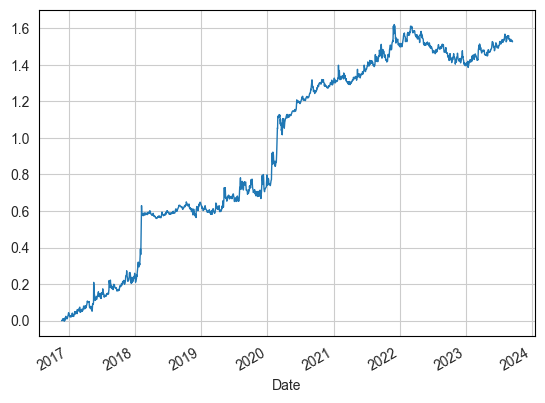

In [25]:
test_period_returns = log_returns[-len(test_outputs):]

optimal_weights = pd.DataFrame(
    test_outputs, 
    index=test_period_returns.index, 
    columns=test_period_returns.columns
)

optimal_weights = optimal_weights.shift()[1:]
test_period_returns = test_period_returns.reindex(optimal_weights.index)

optimal_portfolio_returns = (optimal_weights * test_period_returns).sum(axis=1)
optimal_portfolio_returns.loc[optimal_portfolio_returns.index.min()] = 0
optimal_portfolio_returns.name = "MODEL"

optimal_portfolio_returns.cumsum().plot()

[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

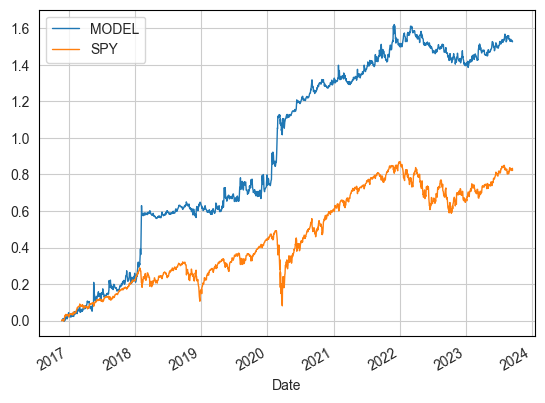

In [26]:
start_date_ = optimal_portfolio_returns.index.min() - pd.DateOffset(days=1)
end_date_ = optimal_portfolio_returns.index.max() + pd.DateOffset(days=1)

benchmark = "SPY"
benchmark_prices = yf.download(benchmark, start_date_, end_date_)["Adj Close"]
benchmark_prices.name = benchmark
benchmark_log_returns = np.log(benchmark_prices).diff()
benchmark_log_returns.loc[benchmark_log_returns.index.min()] = 0

comparison = pd.concat([optimal_portfolio_returns, benchmark_log_returns], axis=1)
comparison.cumsum().plot()

In [36]:
X_test_tens[]

tensor([-0.0042, -0.0070, -0.0023, -0.0304, -0.0023, -0.0050, -0.0254, -0.0376,
        -0.0118,  0.0729])